In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import least_squares, minimize
from sklearn import linear_model
import random
from geneticalgorithm import geneticalgorithm as ga

In [2]:
def f(tc, t, beta):
    return (abs(tc-t))**beta
def g(tc, t, beta, omega):
    return f(tc, t, beta)*np.cos(omega*np.log(abs(tc-t)))
def h(tc, t, beta, omega):
    return f(tc, t, beta)*np.sin(omega*np.log(abs(tc-t)))

In [3]:
def LPPL(t, A, B, C1, C2, beta, omega, tc):
    return A + B*f(tc, t, beta) + C1*g(tc, t, beta, omega) + C2*h(tc, t, beta, omega)

In [4]:
def XOLS(beta, omega, tc, log_price):
    one_col = np.ones(len(log_price))

    t = np.arange(1,len(log_price)+1)
    f_col = f(tc=tc, t=t, beta=beta)
    g_col = g(tc=tc, t=t, beta=beta, omega=omega)
    h_col = h(tc=tc, t=t, beta=beta, omega=omega)

    X = np.array([one_col,f_col,g_col,h_col]).T

    return np.linalg.matrix_rank(X), X

In [5]:
def fit_ABC(beta, omega, tc, log_price):
    r, X = XOLS(beta, omega, tc, log_price)
    if r > 0:
        A, B, C1, C2 = np.linalg.lstsq(X, log_price)[0]
    else:
        #print('rank null')
        A = np.nan
        B = np.nan
        C1 = np.nan
        C2 = np.nan
    return {"A":A, "B":B, "C1":C1, "C2":C2}

In [6]:
def opti_config(log_price):
    beta_m = 0.01
    omega_m = 0

    beta_M = 1.5
    omega_M = 27

    t_first = 0
    t_last = len(log_price)
    t_delta = t_last - t_first
    pct_delta_min = t_delta * 0.2
    pct_delta_max = t_delta * 0.2
    tc_m = t_last - pct_delta_min
    tc_M = t_last + pct_delta_max

    return {"beta_m":beta_m, "omega_m":omega_m, "tc_m":tc_m, "beta_M":beta_M, "omega_M":omega_M, "tc_M":tc_M}

In [7]:
def func_restricted(x, log_price):
    '''
    finds the least square difference
    '''
    tc = x[0]
    beta = x[1]
    omega = x[2]

    fit = fit_ABC(beta, omega, tc, log_price)

    t = np.arange(len(log_price))
    return LPPL(t=t, A=fit['A'], B=fit['B'], C1=fit['C1'], C2=fit['C2'], beta=beta, omega=omega, tc=tc)-log_price

In [8]:
def fit(log_price, max_searches=3):
    config = opti_config(log_price)
    # set random initialization limits for non-linear params
    init_limits = [
        (config['tc_m'], config['tc_M']),  # tc : Critical Time
        (config['beta_m'], config['beta_M']),                
        (config['omega_m'], config['omega_M']),                     
    ]

    search_count = 0
    # find bubble
    sols = []
    normed_residual_min = np.inf
    final_sol = {'tc':np.nan, 'beta':np.nan, 'omega':np.nan, 'A':np.nan, 'B':np.nan, 'C1':np.nan, 'C2':np.nan,'Res':np.nan}
    fun = lambda x: func_restricted(x=x,log_price=log_price)

    while search_count < max_searches:
        #print('search_count' + str(search_count))
        # randomly choose vals within bounds for non-linear params
        rank = 0
        while rank ==0:
            non_lin_vals = [random.uniform(a[0], a[1]) for a in init_limits]
            tc = non_lin_vals[0]
            beta = non_lin_vals[1]
            omega = non_lin_vals[2]
            rank, _ = XOLS(beta, omega, tc, log_price)

        seed = np.array([tc, beta, omega])
        try:
            sol = least_squares(
                fun= fun,
                method='lm',
                x0=seed
            )

            if sol.success:
                tc = sol.x[0]
                beta = sol.x[1]
                omega = sol.x[2]
                # calculate the linear vals again...
                fit_res = fit_ABC(beta, omega, tc, log_price)
                normed_residual = sum(func_restricted(sol.x, log_price)**2)/(7+len(log_price))

                if normed_residual < normed_residual_min:
                    final_sol = {'tc':tc, 'beta':beta, 'omega':omega, 'A':fit_res['A'], 'B':fit_res['B'], 'C1':fit_res['C1'], 'C2':fit_res['C2'],'Res':normed_residual}
                    normed_residual_min = normed_residual
        except Exception as e:
                print('minimize failed: {}'.format(e))
        search_count += 1
    return final_sol

In [9]:
def total_return(log_price):
    price = np.array(np.exp(log_price))
    return (price[-1]-price[0])/price[0]

In [10]:
def get_dt_max(sols, time_windows):
    residuals = [sol['Res'] for sol in sols]
    residuals = pd.DataFrame(residuals).ffill().bfill().values.flatten()
    residuals_lgrn = obtainLagrangeRegularizedNormedCost(residuals, time_windows)
    return time_windows[np.argmin(residuals_lgrn)]


def obtainLagrangeRegularizedNormedCost(residuals, time_windows):
    slope = LagrangeMethod(residuals, time_windows)
    residuals_lgrn = residuals - slope*np.array(list(time_windows))
    return residuals_lgrn

def LagrangeMethod(residuals, time_windows):
    slope = calculate_slope_of_normed_cost(residuals, time_windows)
    return slope[0]

def calculate_slope_of_normed_cost(residuals, time_windows):
    regr =linear_model.LinearRegression(fit_intercept=False)
    x_residuals = np.array(list(time_windows))
    x_residuals = x_residuals.reshape(len(residuals),1)
    res = regr.fit(x_residuals, residuals)
    return res.coef_

In [19]:
def conditions_satisfied(beta, omega, tc, A, B, C1, C2, dt):
    c1 = 0.01 < beta < 1.2
    c2 = 2 < np.abs(omega) < 25
    c3 = 0.95*dt < tc < 1.11*dt
    print('tc in interval: ' + str(c3))
    c4 = 2.5 < np.abs(omega)/(2*np.pi)*np.log(abs(tc/(tc-dt)))
    print('number oscillation: ' + str(c4))
    C = np.sqrt(C1**2+C2**2)
    c5 = 0.8 < beta * abs(B) / (omega * abs(C))
    print('damping: ' + str(c5) )
    return c1 and c2 and c3 and c4 and c5 

In [12]:
def LPPL_confidence(log_price, time_windows):
    
    sols = []
    for dt in time_windows:
        sols.append(fit(log_price[-dt:]))

    dt_max = get_dt_max(sols, time_windows)
    print('dt_max:' + str(dt_max))
    LPPL_confidences = []
    total_returns = []
    for dt in time_windows:
        sol = sols.pop(0)
        if dt <= dt_max: 
            if conditions_satisfied(beta=sol['beta'], omega=sol['omega'], tc=sol['tc'], A=sol['A'], B=sol['B'], C1=sol['C1'], C2=sol['C2'], dt=dt):
                LPPL_confidences.append(1)
                total_returns.append(total_return(log_price[-dt:]))
            else:
                LPPL_confidences.append(0)
                total_returns.append(0)
    print(LPPL_confidences)
    return np.mean(LPPL_confidences)*np.sign(np.median(total_returns))


In [13]:
def LPPL_confidence_signal(log_price, time, time_windows):
    
    LPPL_confidence_ts = []
    for t2 in time:
        print('t2:' + str(t2))
        LPPL_confidence_ts.append(LPPL_confidence(log_price=log_price[:t2], time_windows=time_windows))
    return pd.DataFrame(LPPL_confidence_ts,index=time).fillna(0)

In [14]:
short_dt = range(30,35)
medium_dt = range(91,300)
long_dt = range(301,750)

price = pd.read_csv("data.csv")["Closing Price (USD)"]
log_price = np.log(price)

#LPPL_conf_ts = LPPL_confidence_signal(log_price, time=range(1500,1550), time_windows=np.linspace(50,10,50,dtype=int))

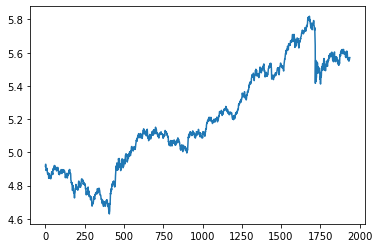

In [15]:
# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
ticker = '^GSPC'

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '1981-01-01'
end_date = '1988-08-30'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader(ticker, 'yahoo', start_date, end_date)
price = panel_data['Adj Close']
log_price = np.log(price)
log_price = log_price.values
plt.plot(log_price)

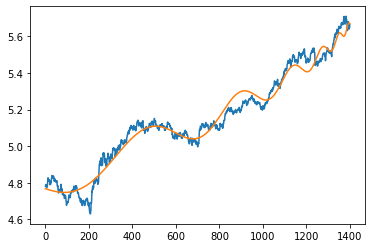

In [27]:
plt.plot(log_price[200:1600])
plt.plot(LPPL(range(1400), sol['A'], sol['B'], sol['C1'], sol['C2'], sol['beta'], sol['omega'], sol['tc']))

In [26]:
sol = fit(log_price[200:1800])
#conditions_satisfied(beta=sol['beta'], omega=sol['omega'], tc=sol['tc'], A=sol['A'], B=sol['B'], C1=sol['C1'], C2=sol['C2'], dt=1300)
sol

{'tc': 1450.4628042861282,
 'beta': 0.5615436850199214,
 'omega': 11.043613278907449,
 'A': 5.8168864744345825,
 'B': -0.01689558447875478,
 'C1': 0.0015328693105121245,
 'C2': 0.0011876355189729079,
 'Res': 0.002843900451760243}

In [28]:
conditions_satisfied(beta=sol['beta'], omega=sol['omega'], tc=sol['tc'], A=sol['A'], B=sol['B'], C1=sol['C1'], C2=sol['C2'], dt=1400)

tc in interval: True
number oscillation: True
damping: False


False

In [ ]:
beta = 0.44
omega = 6.5
C1 = - 0.0001
C2 = 0.0005
A = 1.8259
B = - 0.0094
tc = 805
log_price = LPPL(t=np.arange(800), A=A, B=B, C1=C1, C2=C2, beta=beta, omega=omega, tc=tc)
#log_price = np.append(log_price[300::-1],log_price)
plt.plot(log_price)

In [65]:
def func(x, log_price):
    '''
    finds the least square difference
    '''
    tc, beta, omega = wrapper_scaling(x,log_price)
    # print('shape: {}'.format(obs.shape))
    fit = fit_ABC(beta, omega, tc, log_price)

    t = np.arange(len(log_price))
    return np.sum((LPPL(t=t, A=fit['A'], B=fit['B'], C1=fit['C1'], C2=fit['C2'], beta=beta, omega=omega, tc=tc)-log_price)**2)

In [ ]:
def wrapper_scaling(x,log_price):
    tc_s = x[0]
    beta_s = x[1]
    omega_s = x[2]
    return [tc_s*len(log_price), beta_s, omega_s*10]

In [ ]:

varbound=np.array([[600,1000],[0,1],[0,25]])

model=ga(function=lambda x: func(x,log_price),dimension=3,variable_type='real',variable_boundaries=varbound, algorithm_parameters={'max_num_iteration': 1000,\
                                       'population_size':100,\
                                       'mutation_probability':0.5,\
                                       'elit_ratio': 0.01,\
                                       'crossover_probability': 0.5,\
                                       'parents_portion': 0.3,\
                                       'crossover_type':'uniform',\
                                       'max_iteration_without_improv':1000})

model.run()

In [30]:
import cma

In [69]:
config = opti_config(log_price)
    # set random initialization limits for non-linear params
init_limits = [
    (config['tc_m'], config['tc_M']),  # tc : Critical Time
    (config['beta_m'], config['beta_M']),                
    (config['omega_m'], config['omega_M']),                     
]

rank=0
while rank ==0:
    non_lin_vals = [random.uniform(a[0], a[1]) for a in init_limits]
    tc = non_lin_vals[0]
    beta = non_lin_vals[1]
    omega = non_lin_vals[2]
    rank, _ = XOLS(beta, omega, tc, log_price)


seed = np.array([tc/len(log_price), beta, omega/10])
     
opti_sol = cma.fmin(lambda x: func(x,log_price),sigma0=2,x0=seed)

(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=581150, Wed Aug 26 16:12:28 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 1.315871236499877e+01 1.0e+00 9.77e-01  9e-01  1e+00 0:00.0
    2     14 1.284187372919729e+01 1.4e+00 7.72e-01  6e-01  9e-01 0:00.0
    3     21 1.149517820460757e+01 1.7e+00 7.61e-01  6e-01  9e-01 0:00.0
  100    700 6.271745810054329e+00 3.7e+01 3.45e-02  7e-05  2e-03 0:00.9
  147   1029 6.271745371557834e+00 2.8e+01 1.88e-04  3e-08  8e-07 0:01.2
termination on tolfun=1e-11 (Wed Aug 26 16:12:30 2020)
final/bestever f-value = 6.271745e+00 6.271745e+00
incumbent solution: [1680.2710714225607, 0.620971902192125, 12.278511644745237]
std deviation: [8.173420264062405e-07, 2.905559767429526e-08, 1.5311956491799895e-07]


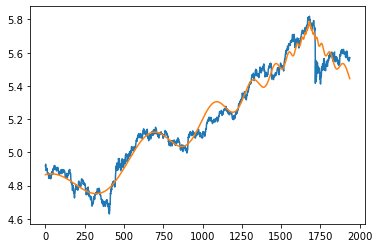

In [70]:
tc, beta, omega = opti_sol[0]
fit_res = fit_ABC(beta, omega, tc, log_price)
sol = {'tc':tc, 'beta':beta, 'omega':omega, 'A':fit_res['A'], 'B':fit_res['B'], 'C1':fit_res['C1'], 'C2':fit_res['C2'],'Res':normed_residual}
plt.plot(log_price)
plt.plot(LPPL(range(len(log_price)), sol['A'], sol['B'], sol['C1'], sol['C2'], sol['beta'], sol['omega'], sol['tc']))

In [52]:
sol

{'tc': 1768.7901057130412,
 'beta': -5.180881715787089,
 'omega': 7.966604909250655,
 'A': 5.196715024795638,
 'B': 0.3983125175948577,
 'C1': -0.4625088360177292,
 'C2': 0.46870695641768484,
 'Res': 3.7378622635048046e-30}

In [41]:
help(cma.fmin)

Help on function fmin in module cma.evolution_strategy:

fmin(objective_function, x0, sigma0, options=None, args=(), gradf=None, restarts=0, restart_from_best='False', incpopsize=2, eval_initial_x=False, parallel_objective=None, noise_handler=None, noise_change_sigma_exponent=1, noise_kappa_exponent=0, bipop=False, callback=None)
    functional interface to the stochastic optimizer CMA-ES
    for non-convex function minimization.
    
    Calling Sequences
    ``fmin(objective_function, x0, sigma0)``
        minimizes ``objective_function`` starting at ``x0`` and with
        standard deviation ``sigma0`` (step-size)
    ``fmin(objective_function, x0, sigma0, options={'ftarget': 1e-5})``
        minimizes ``objective_function`` up to target function value 1e-5,
        which is typically useful for benchmarking.
    ``fmin(objective_function, x0, sigma0, args=('f',))``
        minimizes ``objective_function`` called with an additional
        argument ``'f'``.
    ``fmin(objective_func